# Description

# Libraries

In [8]:
############# Libaries ###############

import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import math
import time
import itertools
from itertools import product, zip_longest
import pickle
from tqdm import tqdm, trange
from datetime import date

import sys
import os

# Options

In [9]:
add_mask = True             #Add a mask to the data - this mask eliminates data below a threshold (mas_amplitude)
subsection = False           #Looks at a region a sixteenth of the full size
apply_normalizer = True     #Normalizes the data during the processing step
estimate_offset = True      #Adds an offset to the signal that is estimated
multistart_method = False    #Applies a multistart method for each parameter fitting instance

# Hyperparameters

In [10]:
brain_data = scipy.io.loadmat(os.getcwd() + '/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_slice5.mat')
I_raw = brain_data['slice_oi']

if subsection:
    I_raw_x = I_raw.shape[0]//4
    I_raw_y = I_raw.shape[1]//4
    I_raw = I_raw[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y, :]

n_vert, n_hori, n_elements_brain = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)

# #This is how we will keep track of all voxels that are called --------------------------------- no iterator for voxels needed
# target_iterator = np.array([item for item in itertools.product(np.arange(0,n_vert,1), np.arange(0,n_hori,1))])

# all pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 750

if multistart_method:
    num_nultistarts = 10
    ms_upper_bound = [1,60,300] 
else:
    num_multistarts = 1
    ms_upper_bound = [0] 

param_name_list_biX = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']
param_name_list_moX = [r'$c_1$',r'$T_{21}$']

if subsection:
    vert1 = 37
    vert2 = 47
    hori1 = 25
    hori2 = 70
else:
    vert1 = 165             #60     #108
    vert2 = 180            #125     #116
    hori1 = 120            #100      #86
    hori2 = 180            #115      #93

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]


# Functions

In [11]:
def G_off_biX(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_off_moX(t, con_1, tau_1, offSet): 
    function = con_1*np.exp(-t/tau_1) + offSet
    return function

def G_biX(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_moX(t, con_1, tau_1): 
    function = con_1*np.exp(-t/tau_1)
    return function

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

In [12]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def get_brain_outline(raw):
    I_outline = np.zeros((n_hori,n_vert))
    for i_vert in range(n_vert):
        for i_hori in range(n_vert):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                init_sig_up = raw[i_vert-1, i_hori, 0]
                init_sig_lt = raw[i_vert, i_hori-1, 0]
                init_sig_rt = raw[i_vert, i_hori+1, 0]
                init_sig_dn = raw[i_vert+1, i_hori, 0]
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = 0
    return I_outline

def normalize_brain(I_data):
    n_vert, n_hori, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_vert in range(n_hori):
        for i_hori in range(n_vert):
            data = I_data[i_vert,i_hori,:]
            if data[0]>0:
                data_normalized = data/(data[0])
            else:
                data_normalized = np.zeros(n_elements_brain)
            I_normalized[i_vert,i_hori,:] = data_normalized
    return I_normalized

def get_param_p0(function, sig_init = 1):
    f_name = function.__name__

    if 'biX' in f_name:
        init_p0 = [sig_init*0.2, sig_init*0.8, 20, 80]
    elif 'moX' in f_name:
        init_p0 = [sig_init, 20]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        init_p0.append(1)

    return init_p0

def check_param_order(popt, func):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    
    f_name = func.__name__
    num = 0
    if 'off' in f_name:
        num = -1

    if (popt[-2+num] > popt[-1+num]): #We want by convention to make sure that T21 is <= T22
        for i in range(popt.shape[0]//2):
            p_hold = popt[2*i]
            popt[2*i] = popt[2*i+1]
            popt[2*i+1] = p_hold
    return popt

def get_param_num(function):
    f_name = function.__name__
    num = 0
    if 'off' in f_name:
        num = 1
    if 'biX' in f_name:
        num = num + 4
    elif 'moX' in f_name:
        num = num + 2
    else:
        raise Exception("Not a valid function: " + f_name)

    return num

def get_param_UB(function):
    f_name = function.__name__

    if 'biX' in f_name:
        upper_bound = [0.5,1.5,80,300]
    elif 'moX' in f_name:
        upper_bound = [1.5,300]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        upper_bound.append(np.inf)

    return upper_bound

def get_param_LB(function):
    f_name = function.__name__

    if 'biX' in f_name:
        lower_bound = [0,0,0,0]
    elif 'moX' in f_name:
        lower_bound = [0,0]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        lower_bound.append(0)

    return lower_bound

def get_error(function):
    f_name = function.__name__

    if 'biX' in f_name:
        error_mat = [0,0,1,1]
    elif 'moX' in f_name:
        error_mat = [0,1]
    else:
        raise Exception("Not a valid function: " + f_name)
    
    if 'off' in f_name:
        error_mat.append(0)

    return error_mat

def calc_region_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)
    regionEnd_absMean = np.mean(np.abs(regionEnd))

    SNR_region = (regionZero_mean - regionEnd_absMean)/regionEnd_std

    return SNR_region

def calc_Radu_SNR(sig, est_curve):
    residuals = sig - est_curve
    curve_std = np.max([np.std(residuals), 10**-16])
    return sig[0]/curve_std

def calc_mag_SNR(sig):
    flat_curve = sig[-5:]
    flat_curve_avg = np.mean(flat_curve)
    assert(np.all(np.abs(flat_curve - flat_curve_avg)<0.05))
    return sig[0]/flat_curve_avg

def calc_std_SNR(sig):
    flat_curve = sig[-5:]
    flat_curve_avg = np.mean(flat_curve)
    assert(np.all(np.abs(flat_curve - flat_curve_avg)<0.05))
    curve_std = np.std(flat_curve)
    return sig[0]/curve_std

def calc_Rician_SNR(sig):
    flat_curve = sig[-5:]
    flat_curve_avg = np.mean(flat_curve)
    assert(np.all(np.abs(flat_curve - flat_curve_avg)<0.05))
    curve_std = flat_curve_avg*(2/np.pi)**(1/2)
    return sig[0]/curve_std

In [13]:
def estimate_parameters(data, func, n_initials = num_multistarts):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual

    RSS_hold = 0
    for i in range(n_initials):

        np.random.seed(i) #Only has an effect on the multistart strategy

        init_params = get_param_p0(func, sig_init = data[0])

        temp_upper_bound = get_param_UB(func)
        if not apply_normalizer:
            temp_upper_bound[0] = data[0]*temp_upper_bound[0]
            temp_upper_bound[1] = data[0]*temp_upper_bound[1]
        
        try:
            lower_bound = get_param_LB(func)
            popt, _ = curve_fit(func, tdata, data, bounds = (lower_bound, temp_upper_bound), p0=init_params, max_nfev = 4000)
        except Exception as error:
            popt = get_error(func)
            print("Error in parameter fitting: " + str(error))

        est_curve = func(tdata,*popt)
        RSS_temp = np.sum((est_curve - data)**2)

        # if RSS_temp < RSS_hold:
        best_popt = popt
        RSS_hold = RSS_temp
        
    popt = check_param_order(best_popt, func)
 
    return popt, RSS_hold


def generate_all_estimates(brain_data_3D, func):
    #Generates a comprehensive matrix of all parameter estimates for all param combinations, 
    #noise realizations, SNR values, and lambdas of interest
    
    RSS_list = np.zeros((brain_data_3D.shape[0],brain_data_3D.shape[1]))
    param_list = np.zeros((brain_data_3D.shape[0],brain_data_3D.shape[0],get_param_num(func)))
    SNR_list = np.zeros((brain_data_3D.shape[0],brain_data_3D.shape[1]))

    for ii in trange(brain_data_3D.shape[0]):
        for jj in range(brain_data_3D.shape[1]):

            noise_data = brain_data_3D[ii, jj, :]
            assert(noise_data.shape[0] == n_elements_brain)

            if noise_data[0] == 0:
                param_estimates = get_error(func)
                RSS_estimate = 0
            else:
                param_estimates, RSS_estimate = estimate_parameters(noise_data, func)
                
            param_list[ii,jj,:] = param_estimates
            RSS_list[ii,jj] = RSS_estimate
            SNR_list[ii,jj] = calc_Radu_SNR(noise_data, func(tdata, *param_estimates))

    return param_list, RSS_list, SNR_list

# Generate Fit Data

In [14]:
#### This ensures that the same mask is applied throughout

if add_mask:
    I_masked = mask_data(I_raw, mask_amplitude)
    I_mask_factor = (I_masked!=0)
else:
    I_masked = I_raw
    I_mask_factor = (I_masked!=0)

#### Generate the standard reference

if apply_normalizer:
    stand_ref = normalize_brain(I_masked)
else:
    stand_ref = I_masked

pest_biX_off_params, pest_biX_off_RSS, pest_biX_off_SNR = generate_all_estimates(stand_ref, G_off_biX)

pest_moX_off_params, pest_moX_off_RSS, pest_moX_off_SNR = generate_all_estimates(stand_ref, G_off_moX)



100%|██████████| 288/288 [01:00<00:00,  4.79it/s]


### Pixel Specific Analysis

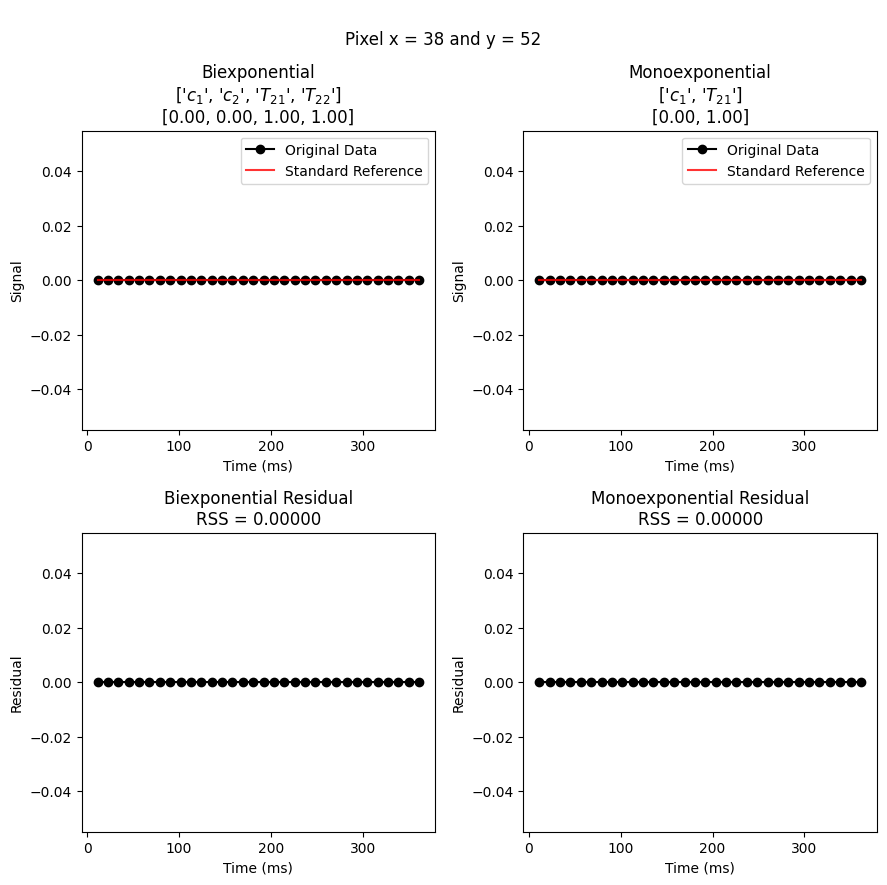

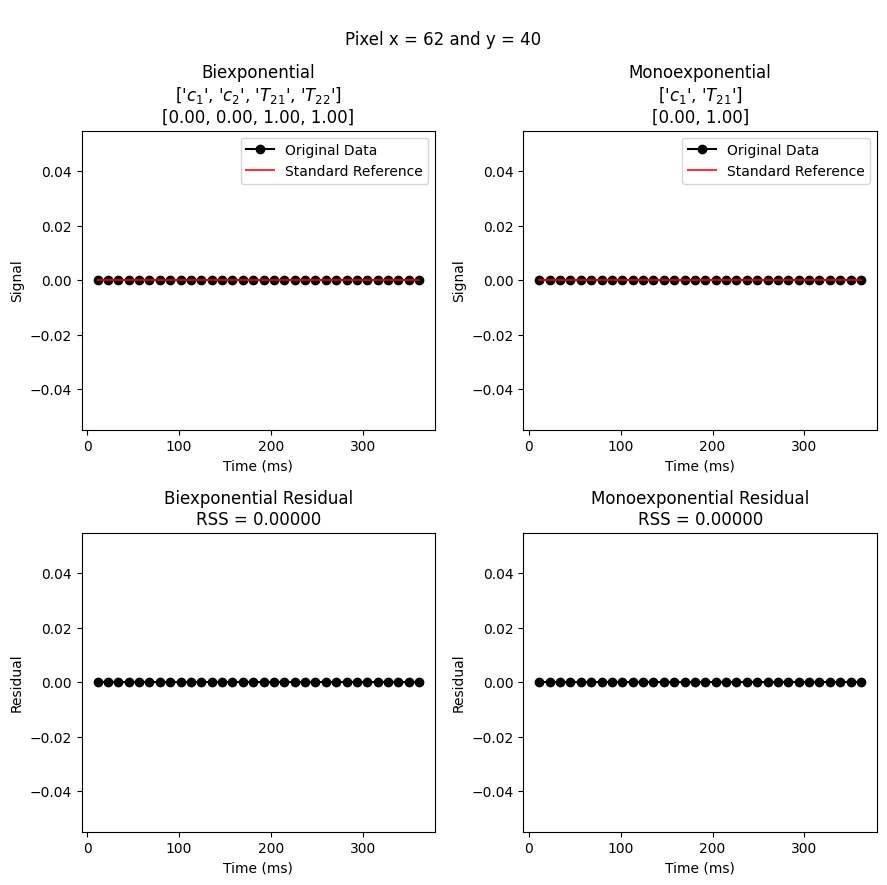

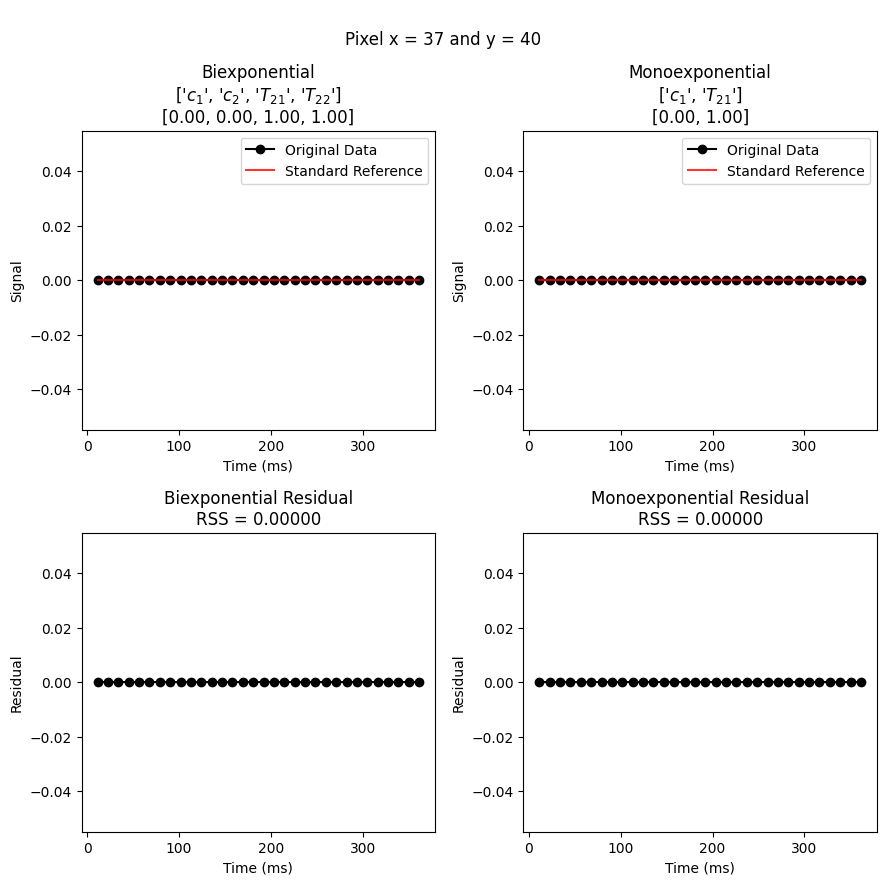

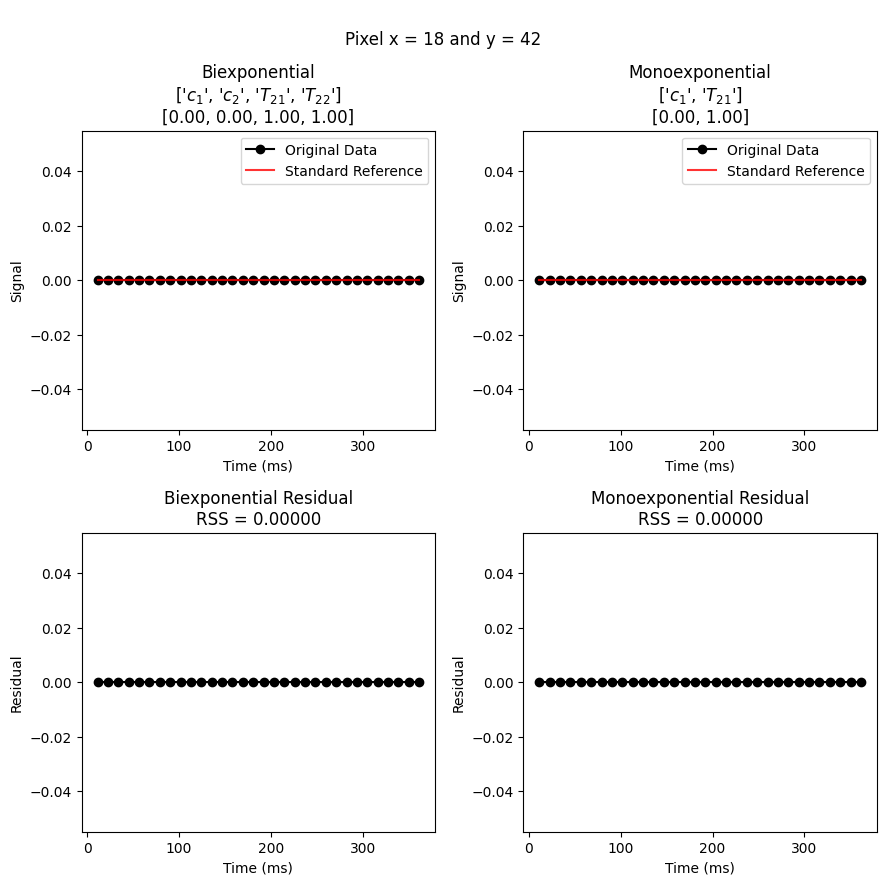

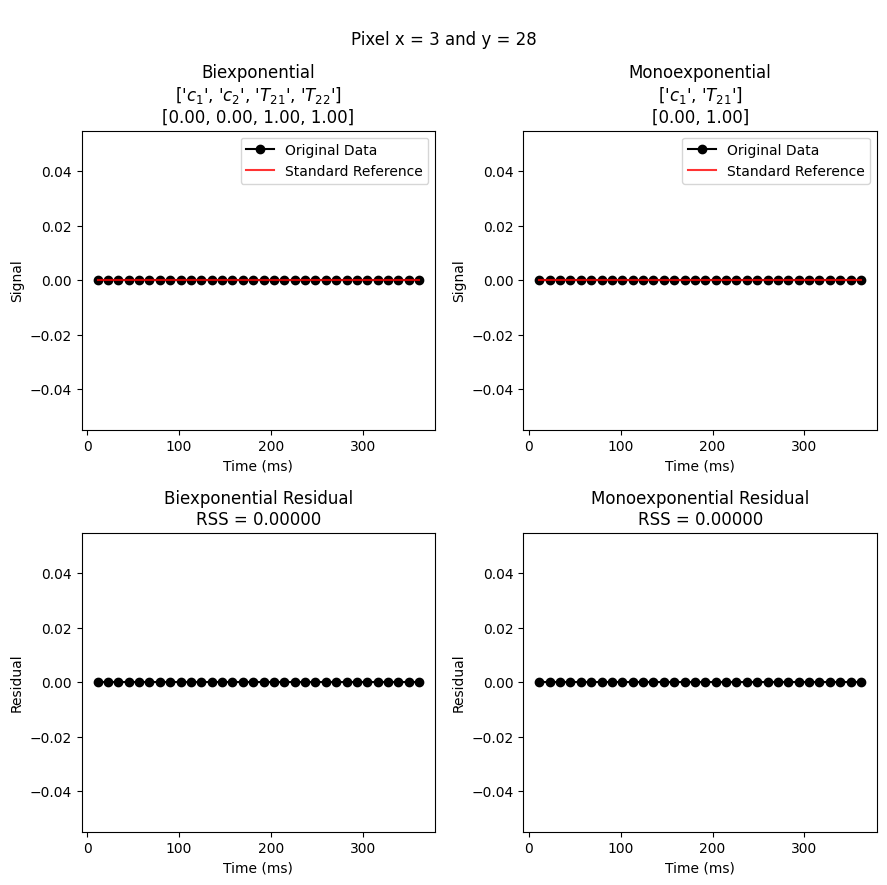

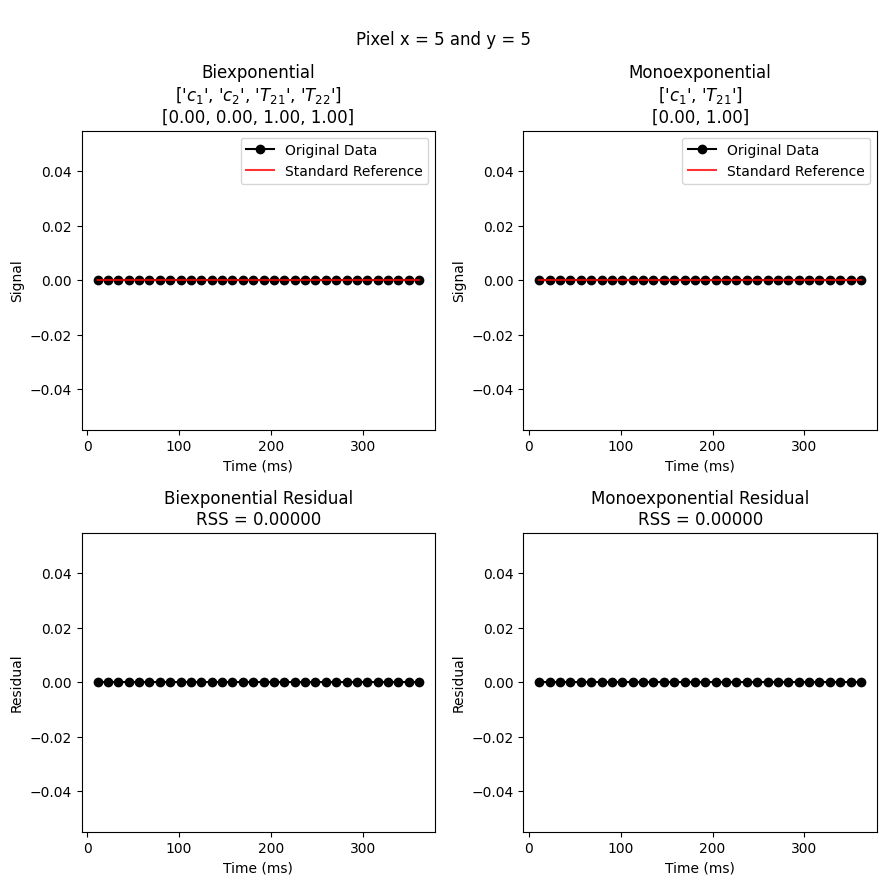

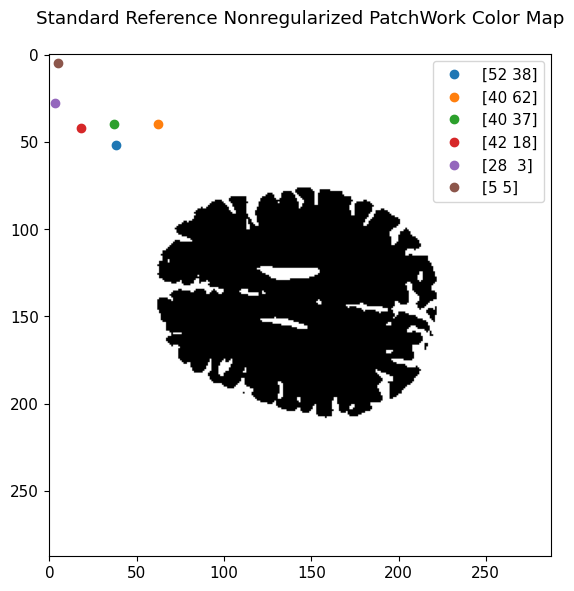

In [15]:
pixels = np.array([[52,38],[40,62],[40,37],[42,18],[28,3],[5,5]])

for pix in range(pixels.shape[0]):
    pix_x, pix_y = pixels[pix, :]
    fig, ax = plt.subplots(2,2,figsize=(9,9),tight_layout=True)
    plt.suptitle(f"\nPixel x = {pixels[pix,1]} and y = {pixels[pix,0]}")
    ax[0,0].plot(tdata, stand_ref[pix_x,pix_y,:], color = 'k', label = "Original Data", marker = 'o')
    ax[0,0].plot(tdata, G_off_biX(tdata, *pest_biX_off_params[pix_x, pix_y, :]), label = "Standard Reference", alpha = 0.8, ls = "-", color = 'r')
    ax[0,0].set_xlabel('Time (ms)')
    ax[0,0].set_ylabel('Signal')
    ax[0,0].set_title("Biexponential\n" + f"{param_name_list_biX}\n[{pest_biX_off_params[pix_x, pix_y, 0]:.2f}, {pest_biX_off_params[pix_x, pix_y, 1]:.2f}, {pest_biX_off_params[pix_x, pix_y, 2]:.2f}, {pest_biX_off_params[pix_x, pix_y, 3]:.2f}]")
    ax[0,0].legend()

    ax[1,0].plot(tdata, stand_ref[pix_x,pix_y,:] - G_off_biX(tdata, *pest_biX_off_params[pix_x, pix_y, :]), color = 'k', marker = 'o')
    ax[1,0].set_xlabel('Time (ms)')
    ax[1,0].set_ylabel('Residual')
    ax[1,0].set_title(f"Biexponential Residual\nRSS = {pest_biX_off_RSS[pix_x,pix_y]:0.5f}")
    

    ax[0,1].plot(tdata, stand_ref[pix_x,pix_y,:], color = 'k', label = "Original Data", marker = 'o')
    ax[0,1].plot(tdata, G_off_moX(tdata, *pest_moX_off_params[pix_x, pix_y, :]), label = "Standard Reference", alpha = 0.8, ls = "-", color = 'r')
    ax[0,1].set_xlabel('Time (ms)')
    ax[0,1].set_ylabel('Signal')
    ax[0,1].set_title("Monoexponential\n" + f"{param_name_list_moX}\n[{pest_moX_off_params[pix_x, pix_y, 0]:.2f}, {pest_moX_off_params[pix_x, pix_y, 1]:.2f}]")
    ax[0,1].legend()

    ax[1,1].plot(tdata, stand_ref[pix_x,pix_y,:] - G_off_moX(tdata, *pest_moX_off_params[pix_x, pix_y, :]), color = 'k', marker = 'o')
    ax[1,1].set_xlabel('Time (ms)')
    ax[1,1].set_ylabel('Residual')
    ax[1,1].set_title(f"Monoexponential Residual\nRSS = {pest_moX_off_RSS[pix_x,pix_y]:0.5f}")


plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Standard Reference Nonregularized PatchWork Color Map")
imc1 = ax.imshow(1-stand_ref[:,:,0], cmap = 'gray')
for ii in range(pixels.shape[0]):
    ax.plot(pixels[ii,1], pixels[ii,0], marker = 'o', ls = '', label = f'{pixels[ii,:]}')
ax.legend()



# SNR Evaluation

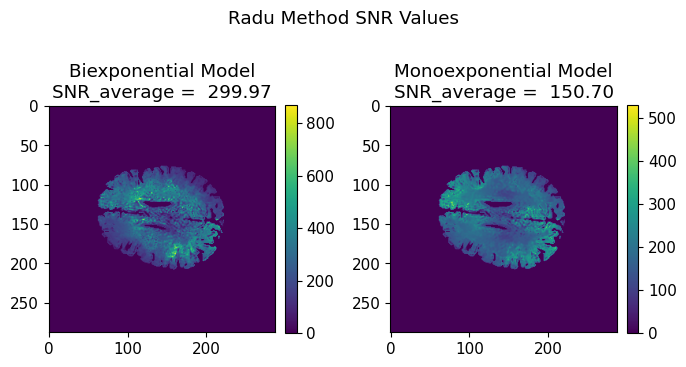

In [16]:
plt.rc('font', size  = 11)
fig, ax = plt.subplots(1,2, figsize = (7, 4), tight_layout=True)
fig.suptitle(f"Radu Method SNR Values")

ax[0].set_title(f"Biexponential Model\nSNR_average = {np.mean(pest_biX_off_SNR[vert1:vert2,hori1:hori2]): 0.2f}")
imc1 = ax[0].imshow(pest_biX_off_SNR)
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)

ax[1].set_title(f"Monoexponential Model\nSNR_average = {np.mean(pest_moX_off_SNR[vert1:vert2,hori1:hori2]): 0.2f}")
imc1 = ax[1].imshow(pest_moX_off_SNR)
fig.colorbar(imc1, ax=ax[1], fraction=0.046, pad=0.04)

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\25038070.py:167: RuntimeWarning: invalid value encountered in double_scalars
  return sig[0]/curve_std


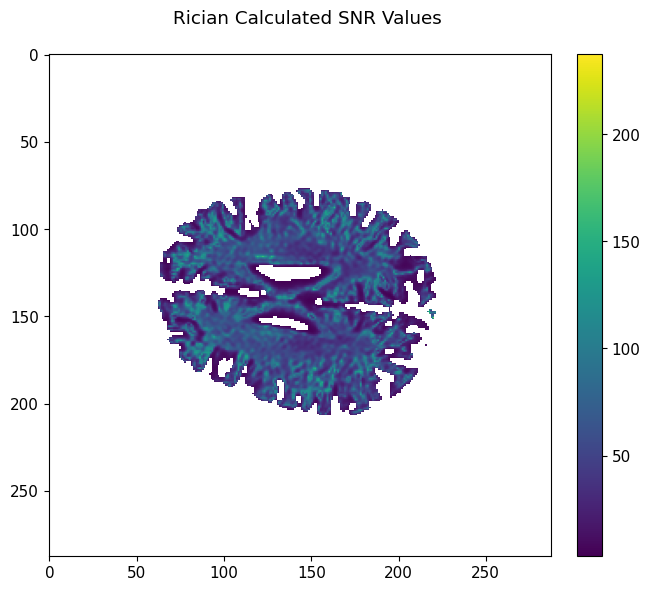

In [17]:
SNR_Rician = np.zeros((n_vert,n_hori))

for ii in range(n_vert):
    for jj in range(n_hori):
        SNR_Rician[ii,jj] = calc_Rician_SNR(stand_ref[ii,jj])

# SNR_hold = calc_Rician_SNR(stand_ref)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Rician Calculated SNR Values")
imc1 = ax.imshow(SNR_Rician)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\25038070.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return sig[0]/flat_curve_avg


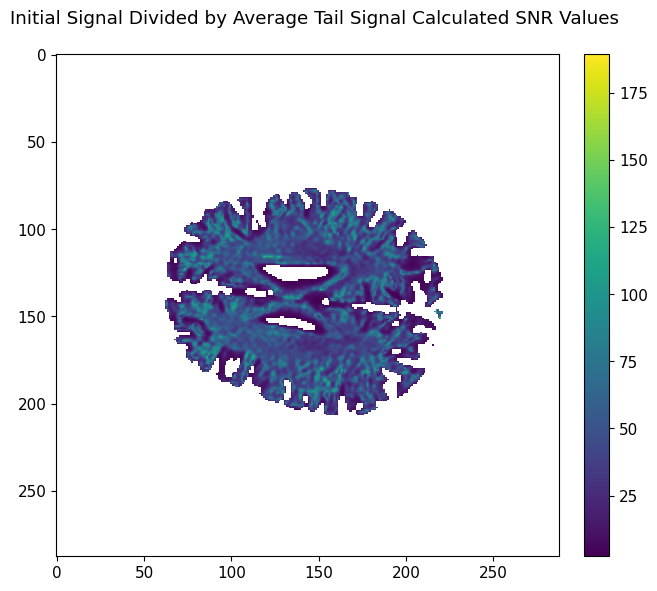

In [18]:
SNR_magnitude = np.zeros((n_vert,n_hori))

for ii in range(n_vert):
    for jj in range(n_hori):
        SNR_magnitude[ii,jj] = calc_mag_SNR(stand_ref[ii,jj])

# SNR_hold = calc_Rician_SNR(stand_ref)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Initial Signal Divided by Average Tail Signal Calculated SNR Values")
imc1 = ax.imshow(SNR_magnitude)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\25038070.py:160: RuntimeWarning: invalid value encountered in double_scalars
  return sig[0]/curve_std


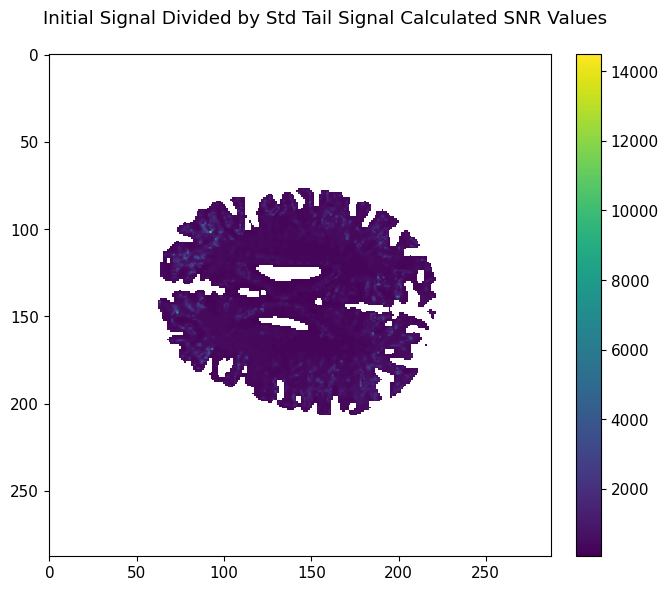

In [19]:
SNR_spread = np.zeros((n_vert,n_hori))

for ii in range(n_vert):
    for jj in range(n_hori):
        SNR_spread[ii,jj] = calc_std_SNR(stand_ref[ii,jj])

# SNR_hold = calc_Rician_SNR(stand_ref)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Initial Signal Divided by Std Tail Signal Calculated SNR Values")
imc1 = ax.imshow(SNR_spread)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

Text(0.5, 1.0, 'SNR Region of Interest')

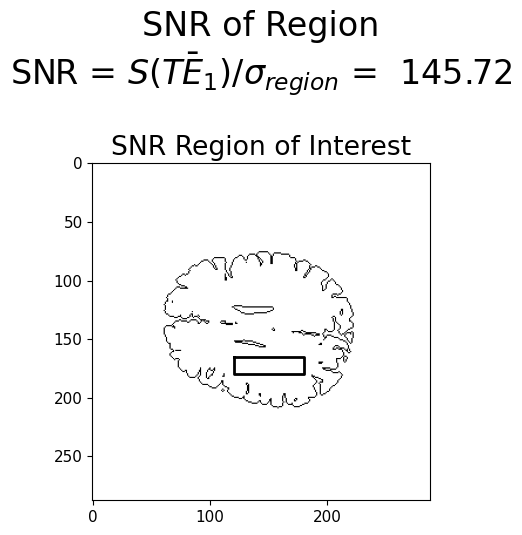

In [20]:
SNR_region = calc_region_SNR(stand_ref, noiseRegion)

brain_outline = get_brain_outline(stand_ref)


fig, ax = plt.subplots(1,1,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'SNR of Region\nSNR = ' + r'${\bar{S(TE_1)}}/\sigma_{region}$' + f' = {SNR_region: 0.2f}')
plt.rc('font', size  = 16)
ax.imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
ax.plot(hBox,vBox, linewidth = 2, color = 'k')
ax.set_title("SNR Region of Interest")
# ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

# Model Selection by Difference in Parameters

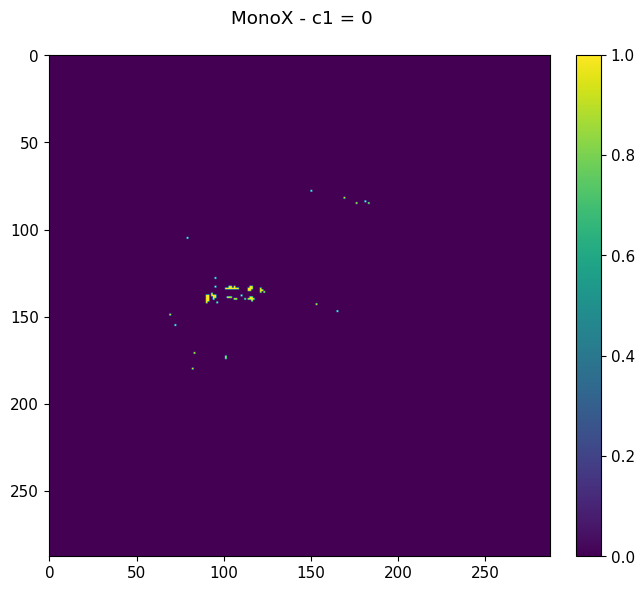

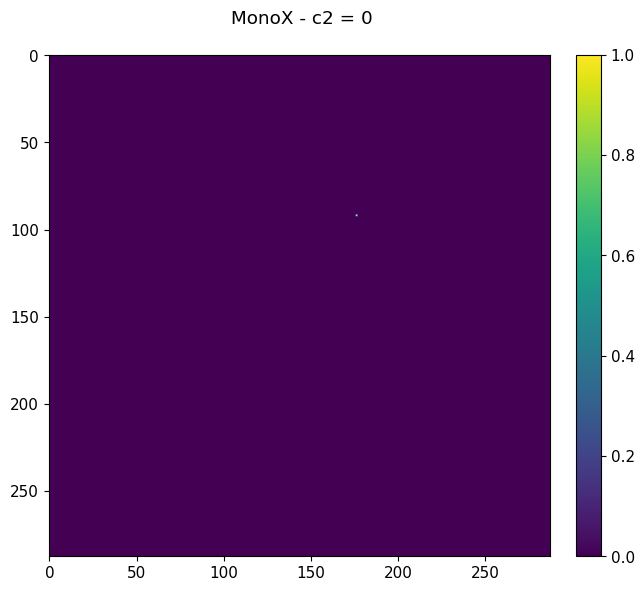

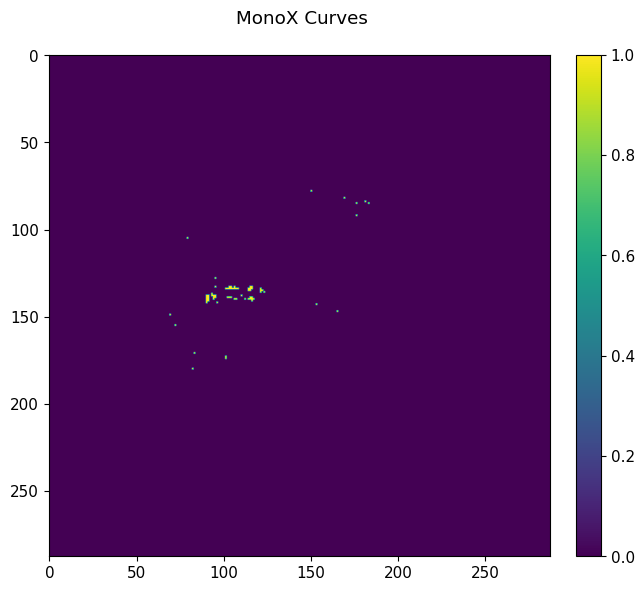

In [21]:
threshold = 0.01

combo1 = (pest_biX_off_params[:,:,0] < threshold) * (pest_biX_off_params[:,:,1] > threshold)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MonoX - c1 = 0")
imc1 = ax.imshow(combo1)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

combo2 = (pest_biX_off_params[:,:,1] < threshold) * (pest_biX_off_params[:,:,0] > threshold)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MonoX - c2 = 0")
imc1 = ax.imshow(combo2)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MonoX Curves")
imc1 = ax.imshow(combo2+combo1)
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# BIC Method

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\3110469667.py:6: RuntimeWarning: divide by zero encountered in log10
  imc1 = ax.imshow(np.log10(pest_biX_off_RSS))
C:\Users\griff\AppData\Local\Temp\ipykernel_14740\3110469667.py:13: RuntimeWarning: divide by zero encountered in log10
  imc1 = ax.imshow(np.log10(pest_moX_off_RSS))


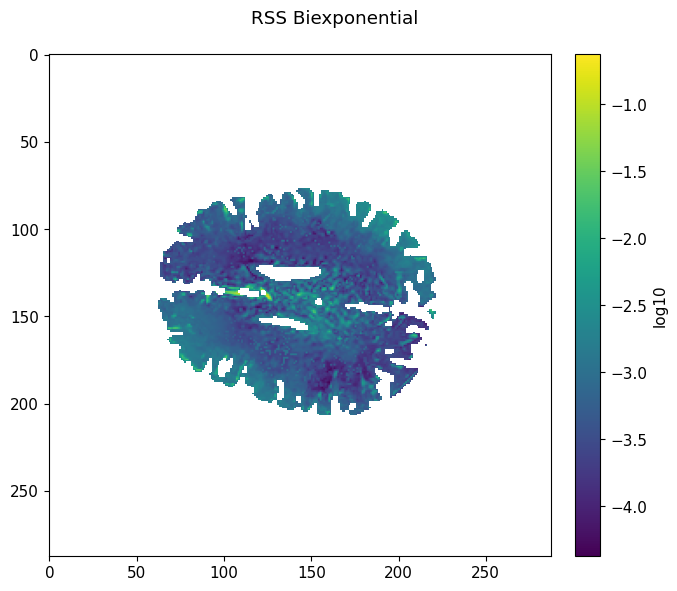

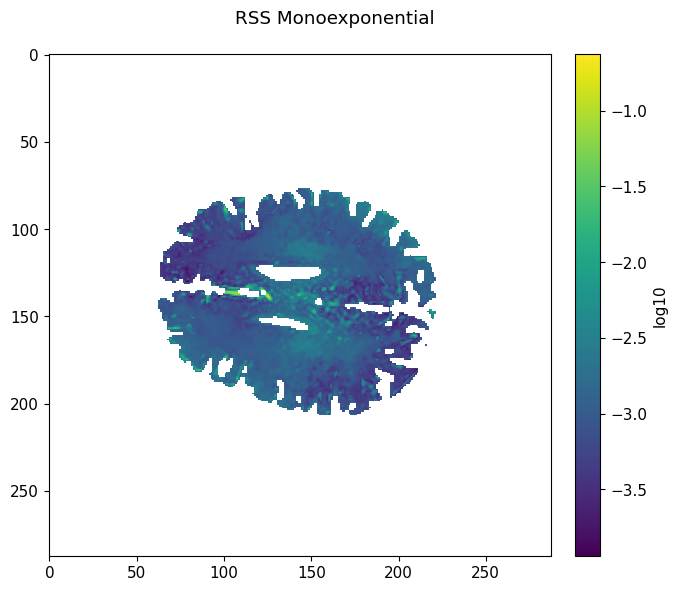

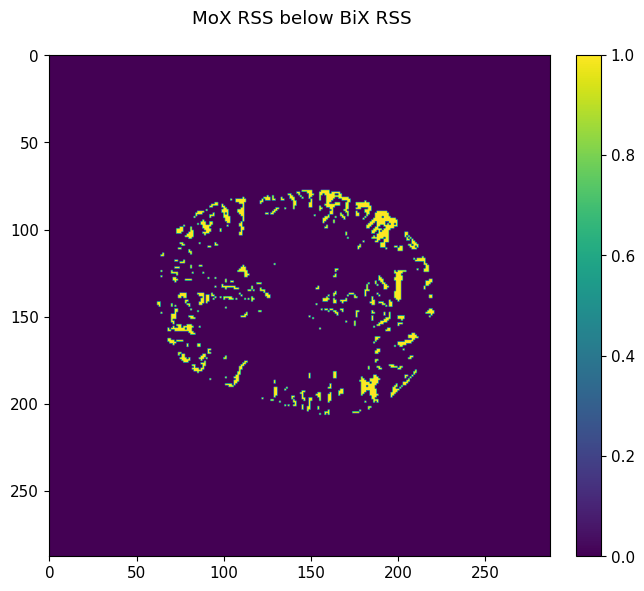

In [22]:
# RSS results

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"RSS Biexponential")
imc1 = ax.imshow(np.log10(pest_biX_off_RSS))

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04, label = "log10")

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"RSS Monoexponential")
imc1 = ax.imshow(np.log10(pest_moX_off_RSS))

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04, label = "log10")

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"MoX RSS below BiX RSS")
imc1 = ax.imshow(pest_moX_off_RSS < pest_biX_off_RSS)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

In [23]:
#BIC Equation

# BIC = 1/n*(RSS + ln(n)*k*sigma**2)
# n is the number of data points in the curve
# RSS is the residual sum of squares
# k is the number of parameters
# sigma is the noise


BIC_2E_Radu = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)
BIC_1E_Radu = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)

BIC_2E_spread = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*(stand_ref[:,:,0]/SNR_spread)**2)
BIC_1E_spread = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*(stand_ref[:,:,0]/SNR_spread)**2)

BIC_2E_mag = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*(stand_ref[:,:,0]/SNR_magnitude)**2)
BIC_1E_mag = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*(stand_ref[:,:,0]/SNR_magnitude)**2)

BIC_2E_Rician = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*(stand_ref[:,:,0]/SNR_Rician)**2)
BIC_1E_Rician = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*(stand_ref[:,:,0]/SNR_Rician)**2)

BIC_2E_region = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*(stand_ref[:,:,0]/SNR_region)**2)
BIC_1E_region = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*(stand_ref[:,:,0]/SNR_region)**2)

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\3666378054.py:10: RuntimeWarning: invalid value encountered in divide
  BIC_2E_Radu = 1/tdata.shape[0] * (pest_biX_off_RSS + np.log(tdata.shape[0]) * 5*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)
C:\Users\griff\AppData\Local\Temp\ipykernel_14740\3666378054.py:11: RuntimeWarning: invalid value encountered in divide
  BIC_1E_Radu = 1/tdata.shape[0] * (pest_moX_off_RSS + np.log(tdata.shape[0]) * 3*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)


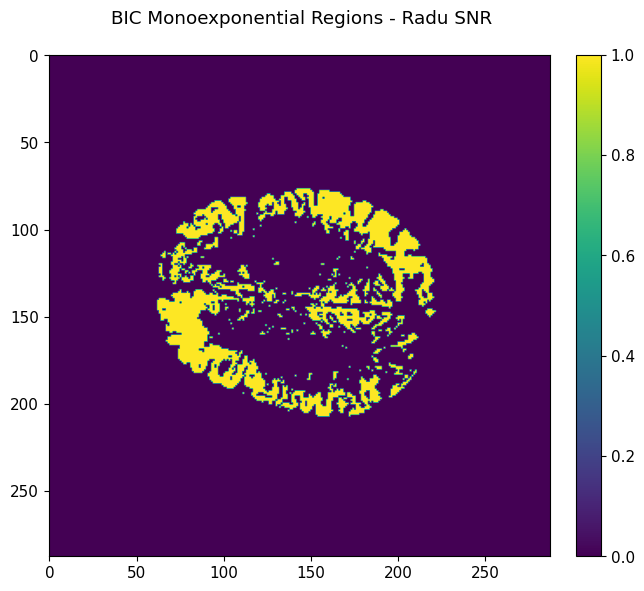

In [24]:
# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Biexponential")
# imc1 = ax.imshow(BIC_2E)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Monoexponential")
# imc1 = ax.imshow(BIC_1E)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

monoX_region_Radu = BIC_1E_Radu<BIC_2E_Radu

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Monoexponential Regions - Radu SNR")
imc1 = ax.imshow(monoX_region_Radu)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_perPix_SNR.npy', monoX_region)

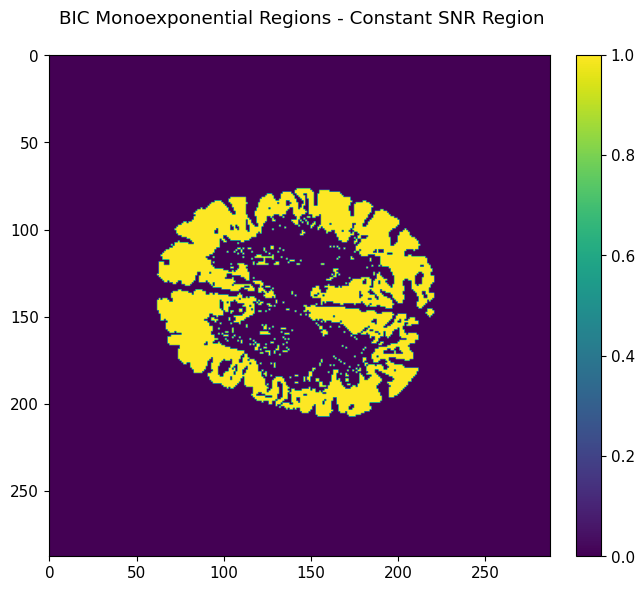

In [25]:

monoX_region_region = BIC_1E_region<BIC_2E_region

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Monoexponential Regions - Constant SNR Region")
imc1 = ax.imshow(monoX_region_region)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_const_SNR.npy', monoX_region)

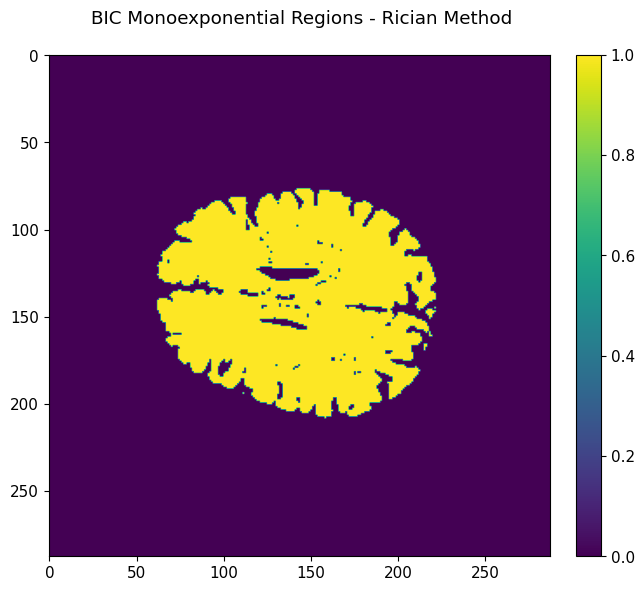

In [26]:
monoX_region_Rician = BIC_1E_Rician<BIC_2E_Rician

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Monoexponential Regions - Rician Method")
imc1 = ax.imshow(monoX_region_Rician)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_Rician_SNR.npy', monoX_region_Rician)

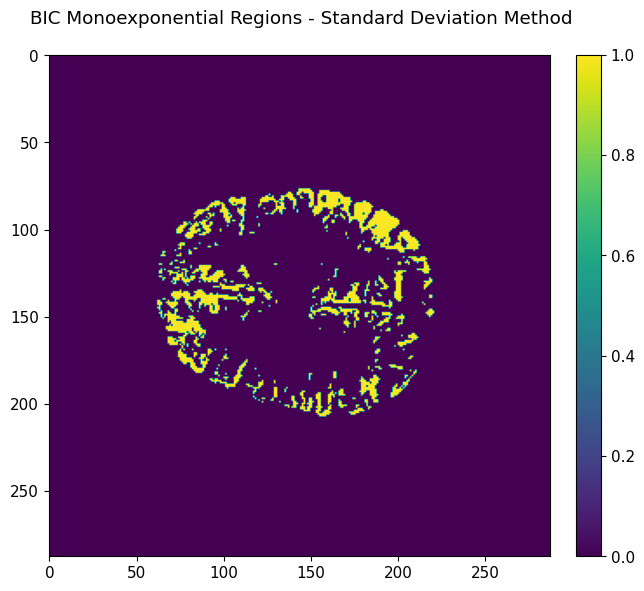

In [27]:
monoX_region_spread = BIC_1E_spread<BIC_2E_spread

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Monoexponential Regions - Standard Deviation Method")
imc1 = ax.imshow(monoX_region_spread)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_spread_SNR.npy', monoX_region_spread)

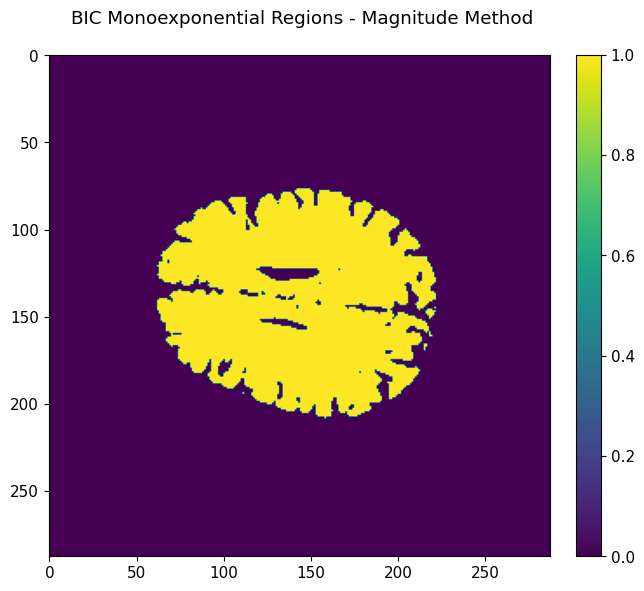

In [28]:
monoX_region_magnitude = BIC_1E_mag<BIC_2E_mag

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"BIC Monoexponential Regions - Magnitude Method")
imc1 = ax.imshow(monoX_region_magnitude)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_mag_SNR.npy', monoX_region_magnitude)

# AIC

In [29]:
#AIC Equation

# AIC = 1/n*(RSS + 2*k*sigma**2)
# n is the number of data points in the curve
# RSS is the residual sum of squares
# k is the number of parameters
# sigma is the noise


AIC_2E_Radu = 1/tdata.shape[0] * (pest_biX_off_RSS + 2 * 5*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)
AIC_1E_Radu = 1/tdata.shape[0] * (pest_moX_off_RSS + 2 * 3*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)

AIC_2E_spread = 1/tdata.shape[0] * (pest_biX_off_RSS + 2 * 5*(stand_ref[:,:,0]/SNR_spread)**2)
AIC_1E_spread = 1/tdata.shape[0] * (pest_moX_off_RSS + 2 * 3*(stand_ref[:,:,0]/SNR_spread)**2)

AIC_2E_mag = 1/tdata.shape[0] * (pest_biX_off_RSS + 2 * 5*(stand_ref[:,:,0]/SNR_magnitude)**2)
AIC_1E_mag = 1/tdata.shape[0] * (pest_moX_off_RSS + 2 * 3*(stand_ref[:,:,0]/SNR_magnitude)**2)

AIC_2E_Rician = 1/tdata.shape[0] * (pest_biX_off_RSS + 2 * 5*(stand_ref[:,:,0]/SNR_Rician)**2)
AIC_1E_Rician = 1/tdata.shape[0] * (pest_moX_off_RSS + 2 * 3*(stand_ref[:,:,0]/SNR_Rician)**2)

AIC_2E_region = 1/tdata.shape[0] * (pest_biX_off_RSS + 2 * 5*(stand_ref[:,:,0]/SNR_region)**2)
AIC_1E_region = 1/tdata.shape[0] * (pest_moX_off_RSS + 2 * 3*(stand_ref[:,:,0]/SNR_region)**2)

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\2289134888.py:10: RuntimeWarning: invalid value encountered in divide
  AIC_2E_Radu = 1/tdata.shape[0] * (pest_biX_off_RSS + 2 * 5*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)
C:\Users\griff\AppData\Local\Temp\ipykernel_14740\2289134888.py:11: RuntimeWarning: invalid value encountered in divide
  AIC_1E_Radu = 1/tdata.shape[0] * (pest_moX_off_RSS + 2 * 3*(stand_ref[:,:,0]/pest_biX_off_SNR)**2)


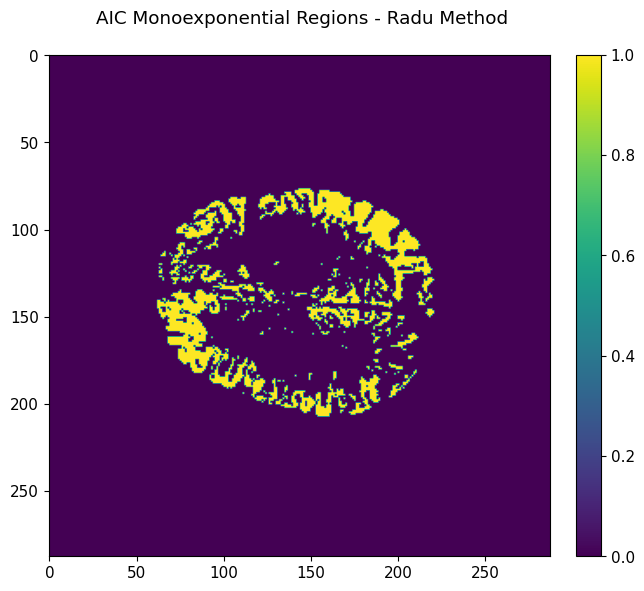

In [30]:
# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Biexponential")
# imc1 = ax.imshow(BIC_2E)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Monoexponential")
# imc1 = ax.imshow(BIC_1E)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

monoX_region_Radu_AIC = AIC_1E_Radu<AIC_2E_Radu

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"AIC Monoexponential Regions - Radu Method")
imc1 = ax.imshow(monoX_region_Radu_AIC)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_perPix_SNR.npy', monoX_region_Radu_AIC)

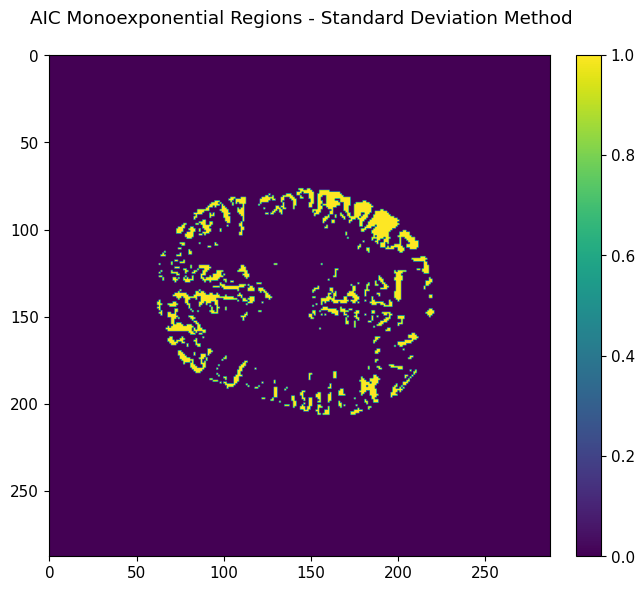

In [31]:
monoX_region_spread_AIC = AIC_1E_spread<AIC_2E_spread

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"AIC Monoexponential Regions - Standard Deviation Method")
imc1 = ax.imshow(monoX_region_spread_AIC)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_perPix_SNR.npy', monoX_region_spread_AIC)

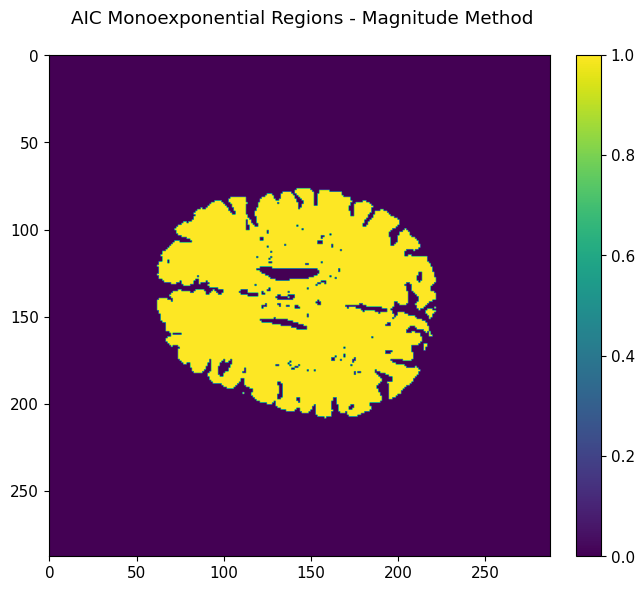

In [32]:
monoX_region_mag_AIC = AIC_1E_mag<AIC_2E_mag

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"AIC Monoexponential Regions - Magnitude Method")
imc1 = ax.imshow(monoX_region_mag_AIC)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_perPix_SNR.npy', monoX_region_mag_AIC)

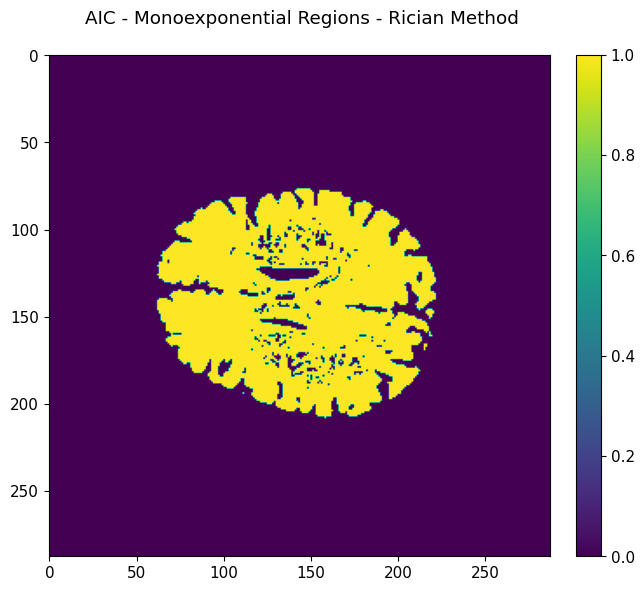

In [33]:
monoX_region_Rician_AIC = AIC_1E_Rician<AIC_2E_Rician

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"AIC - Monoexponential Regions - Rician Method")
imc1 = ax.imshow(monoX_region_Rician_AIC)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_perPix_SNR.npy', monoX_region_Rician_AIC)

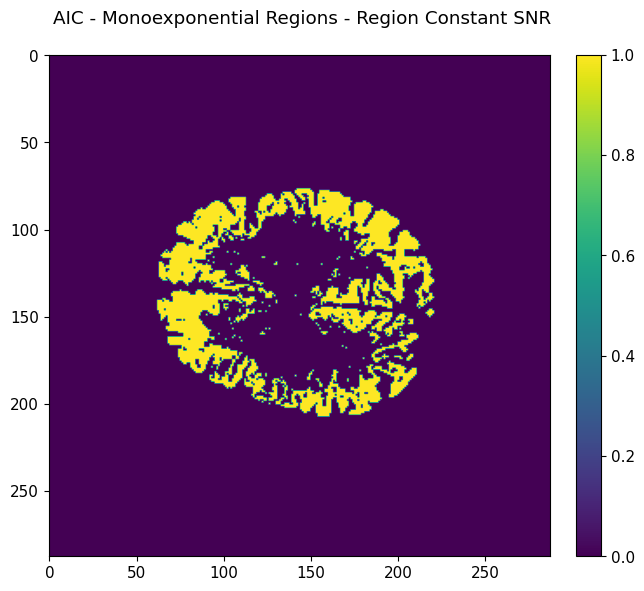

In [34]:
monoX_region_region_AIC = AIC_1E_region<AIC_2E_region

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"AIC - Monoexponential Regions - Region Constant SNR")
imc1 = ax.imshow(monoX_region_region_AIC)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# np.save('SavedMasks/monoX_perPix_SNR.npy', monoX_region_region_AIC)

# Condition Number

In [35]:
biX_off_CN = np.zeros(pest_biX_off_RSS.shape)
biX_off_CN_alt = np.zeros(pest_biX_off_RSS.shape)
biX_off_CN_log = np.zeros(pest_biX_off_RSS.shape)

for ii in range(pest_biX_off_params.shape[0]):
    for jj in range(pest_biX_off_params.shape[1]):
        if I_mask_factor[ii,jj,0]:
            if not monoX_region_Radu[ii,jj]:
                biX_off_CN[ii,jj] = np.linalg.cond(J(tdata, *pest_biX_off_params[ii,jj,:4]))
                # try:
                biX_off_CN_alt[ii,jj] = np.linalg.inv(np.transpose(J(tdata, *pest_biX_off_params[ii,jj,:4])) @ J(tdata, *pest_biX_off_params[ii,jj,:4]))[0,0]
                if biX_off_CN_alt[ii,jj] < 0:
                    print(f"row = {ii} :: col = {jj}")
                    print(pest_biX_off_params[ii,jj,:4])
                    # print(J(tdata, *pest_biX_off_params[ii,jj,:4]))
                    # print(np.transpose(J(tdata, *pest_biX_off_params[ii,jj,:4])) @ J(tdata, *pest_biX_off_params[ii,jj,:4]))
                    # print(np.linalg.inv(np.transpose(J(tdata, *pest_biX_off_params[ii,jj,:4])) @ J(tdata, *pest_biX_off_params[ii,jj,:4])))
                # except:
                #     biX_off_CN_alt[ii,jj] = -1
                #     print(pest_biX_off_params[ii,jj,:4])
                biX_off_CN_log[ii,jj] = np.log10(np.linalg.cond(J(tdata, *pest_biX_off_params[ii,jj,:4])))


In [41]:
print(pest_biX_off_params[80,150,:])
print(pest_moX_off_params[80,150,:])


print(f"RSS for BiX {pest_biX_off_RSS[80,150]}")
print(f"RSS for MoX {pest_moX_off_RSS[80,150]}")

sig_oi = stand_ref[80,150,:]

flat_curve = sig_oi[-5:]
flat_curve_avg = np.mean(flat_curve)
assert(np.all(np.abs(flat_curve - flat_curve_avg)<0.05)) #Curve is relatively flat
sigma_value = flat_curve_avg*(2/np.pi)**(1/2)

#5 parameters since we use the 4 main parameters and the offset
print(f"BiX param term {np.log(tdata.shape[0]) * 5*sigma_value**2}")
#3 parameters since we use the 2 main parameters and the offset
print(f"MoX param term {np.log(tdata.shape[0]) * 3*sigma_value**2}")

#BIC Values Calculated
#5 parameters since we use the 4 main parameters and the offset
print(f"BiX BIC {1/tdata.shape[0]*(pest_biX_off_RSS[80,150] + np.log(tdata.shape[0]) * 5*sigma_value**2)}")
#3 parameters since we use the 2 main parameters and the offset
print(f"MoX BIC {1/tdata.shape[0]*(pest_moX_off_RSS[80,150] + np.log(tdata.shape[0]) * 3*sigma_value**2)}")

if 1/tdata.shape[0]*(pest_biX_off_RSS[80,150] + np.log(tdata.shape[0]) * 5*sigma_value**2) > 1/tdata.shape[0]*(pest_moX_off_RSS[80,150] + np.log(tdata.shape[0]) * 3*sigma_value**2):
    print("Monoexponential Pixel")
else:
    print("Biexponential Pixel")

[2.63394121e-01 9.66841390e-01 5.92829972e+01 5.92878347e+01
 1.62926977e-02]
[1.23023459e+00 5.92869199e+01 1.62924304e-02]
RSS for BiX 0.01435615911522796
RSS for MoX 0.014356159057046907
BiX param term 0.025529207226079043
MoX param term 0.015317524335647426
BiX BIC 0.0012464176981658438
MoX BIC 0.000927302606021698
Monoexponential Pixel


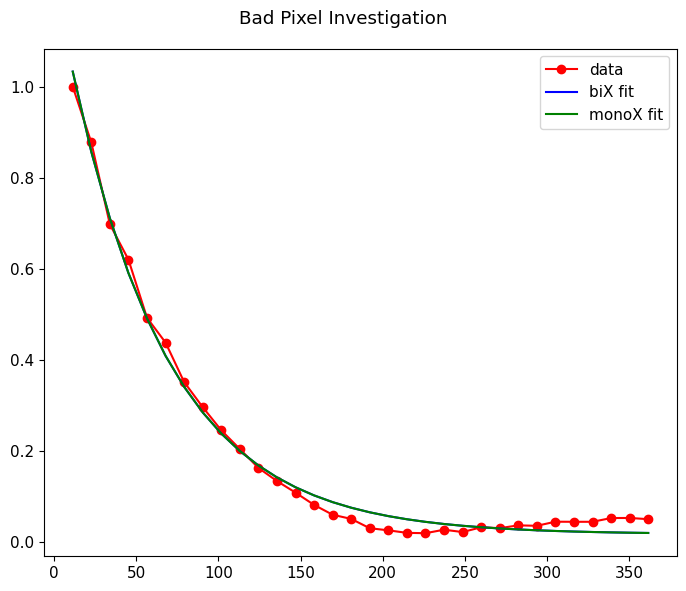

In [37]:
plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Bad Pixel Investigation")
ax.plot(tdata, stand_ref[80,150,:], marker = 'o', color = 'r', label = 'data')
ax.plot(tdata, G_off_biX(tdata, *pest_biX_off_params[80,150,:]), color = 'b', label = 'biX fit')
ax.plot(tdata, G_off_moX(tdata, *pest_moX_off_params[80,150,:]), color = 'g', label = 'monoX fit')
ax.legend()



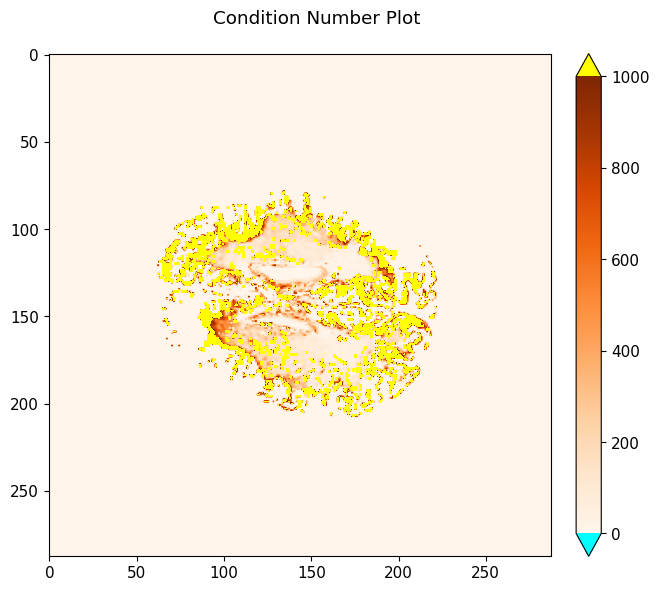

In [38]:
or_map = plt.get_cmap('Oranges')
or_map.set_extremes(over = 'yellow', under = 'cyan')
extend_opt = "both"

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Condition Number Plot")
imc1 = ax.imshow(biX_off_CN_alt, cmap = or_map, vmin = -10**-4, vmax = 1000)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04, extend = extend_opt)

# Generate Noise without Offset

In [39]:
data_offRemoved =  np.reshape(np.reshape(stand_ref, (-1,32)) - np.reshape(pest_biX_off_params[:,:,-1], (-1, 1)), stand_ref.shape )
print(data_offRemoved.shape)
print(stand_ref.shape)

pest_biX_params, pest_biX_RSS, pest_biX_SNR = generate_all_estimates(data_offRemoved, G_biX)

pest_moX_params, pest_moX_RSS, pest_moX_SNR = generate_all_estimates(data_offRemoved, G_moX)

(288, 288, 32)
(288, 288, 32)


100%|██████████| 288/288 [01:15<00:00,  3.83it/s]


# No Offset BIC

C:\Users\griff\AppData\Local\Temp\ipykernel_14740\2906415410.py:1: RuntimeWarning: invalid value encountered in divide
  BIC_2E_deOff = 1/tdata.shape[0] * (pest_biX_RSS + np.log(tdata.shape[0]) * 4*stand_ref[:,:,0]/pest_biX_off_SNR**2)
C:\Users\griff\AppData\Local\Temp\ipykernel_14740\2906415410.py:3: RuntimeWarning: invalid value encountered in divide
  BIC_1E_deOff = 1/tdata.shape[0] * (pest_moX_RSS + np.log(tdata.shape[0]) * 2*stand_ref[:,:,0]/pest_biX_off_SNR**2)


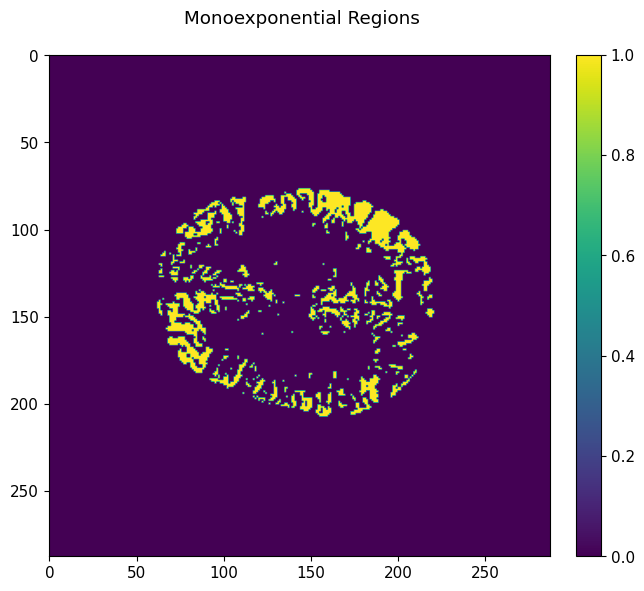

In [40]:
BIC_2E_deOff = 1/tdata.shape[0] * (pest_biX_RSS + np.log(tdata.shape[0]) * 4*stand_ref[:,:,0]/pest_biX_off_SNR**2)

BIC_1E_deOff = 1/tdata.shape[0] * (pest_moX_RSS + np.log(tdata.shape[0]) * 2*stand_ref[:,:,0]/pest_biX_off_SNR**2)

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Biexponential")
# imc1 = ax.imshow(BIC_2E_deOff)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

# plt.rc('font', size  = 11)
# fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
# fig.suptitle(f"BIC Monoexponential")
# imc1 = ax.imshow(BIC_1E_deOff)

# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.rc('font', size  = 11)
fig, ax = plt.subplots(figsize = (7, 6), tight_layout=True)
fig.suptitle(f"Monoexponential Regions")
imc1 = ax.imshow(BIC_1E_deOff<BIC_2E_deOff)

fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)